# 🐦 BIRD RECOGNITION

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dropout
import matplotlib.pyplot as plt

In [23]:
# 1. Charger les données
dataset_path = "images"  # Remplace par le chemin de ton dataset

# 80% entraînement, 20% test
train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# Prétraitement
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


Found 3408 files belonging to 20 classes.
Using 2727 files for training.
Found 3408 files belonging to 20 classes.
Using 681 files for validation.


In [ ]:

# 2. Importer un modèle pré-entraîné (MobileNetV2)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
# Fine-tuning : déverrouiller les dernières 15 couches
base_model.trainable = True

# On freeze toutes les couches sauf les 15 dernières
for layer in base_model.layers[:-15]:
    layer.trainable = False


In [25]:
# 3. Ajouter des couches pour la classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)  # 30% des neurones désactivés pendant l'entraînement
x = BatchNormalization()(x)
predictions = Dense(20, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:

# 4. Compiler le modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
# 5. Entraîner le modèle
history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=[
    EarlyStopping(patience=3, restore_best_weights=True)
])

Epoch 1/10


86/86 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.1842 - loss: 2.9204 - val_accuracy: 0.0631 - val_loss: 13.8007
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.4697 - loss: 1.6990 - val_accuracy: 0.0338 - val_loss: 17.5327
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.5784 - loss: 1.2923 - val_accuracy: 0.0587 - val_loss: 17.3763
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 218s 3s/step - accuracy: 0.6521 - loss: 1.0949 - val_accuracy: 0.0338 - val_loss: 20.4582


In [28]:

# 6. Évaluer les performances
loss, accuracy = model.evaluate(val_ds)
print(f"Accuracy : {accuracy*100:.2f}%")

22/22 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.0702 - loss: 14.0358
Accuracy : 6.31%


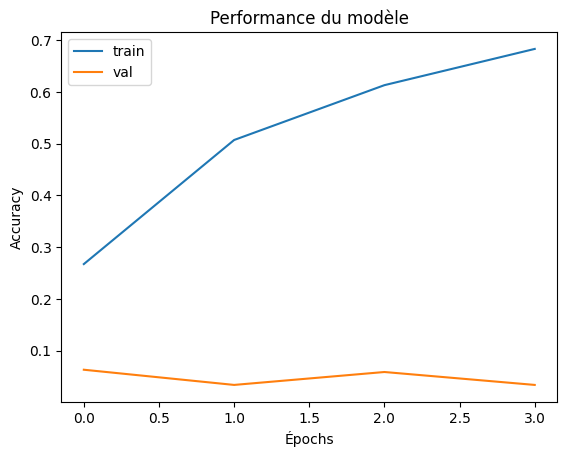

In [29]:

# 7. Afficher l’évolution de l’apprentissage
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Épochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Performance du modèle")
plt.show()